# Problem Set 1 (97 points) 

## Important information
We provide signatures of the functions that you have to implement. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

# Problem 1 (Time series forecasting with simple NLA) (31 pts)

Many daily-life events can be described using **time series**: $x_t$, $t \in \{0, \ldots, n\}$, e.g.
closing price of a stock on day $t$ or number of users on a website in hour $t$.

Below you are given time series example $x \in \mathbb{R}^n$:

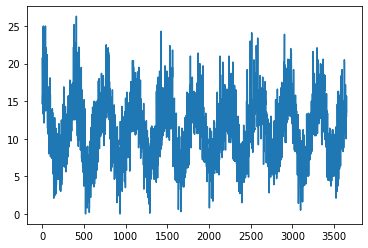

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('./data.csv')
x = data['Val'].values
plt.plot(x)

Raw time dependent data usually looks rather unpretty. However, it can be often considered as a sum of some **trend** + some random **noise**. For example, a periodic trend is easily observed in the series above.

_1._ Your first task is to find **truly** periodic series which will best approximate the original data $x$.

Let $z \in \mathbb{R}^m$ denotes one period of some given periodic data $x_{per} \in \mathbb{R}^n$ (assuming $n$ is miltiple of $m$), i.e.:

$$x_{per} = (z,z,\ldots,z),$$

or in the matrix form:

$$Az = x_{per},$$

with "tall" matrix $A \in \mathbb{R}^{n\times m}$, $n > m$.

The actual data $x$ is non-periodic, hence the solution (in appropriate sense) of the following **overdetermined** linear system is required (think why):

$$Az = x.$$

- (3 pts) Choose $m$ and implement function to construct matrix $A$ according to the template below. What structure does this matrix have?
 *Hint:*  you can use ```numpy.vstack()``` function. Describe how do you choose $m$. Also, suggest what are the data you are working with?

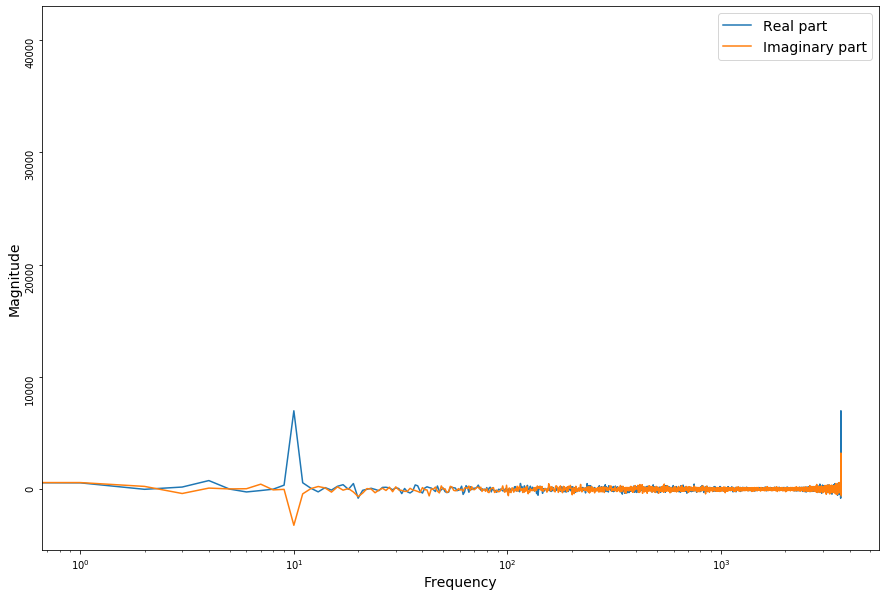

In [2]:
FONTIZE=14

plt.figure(figsize=(15, 10))
fft = np.fft.fft(x)

plt.plot(fft.real, label='Real part')
plt.plot(fft.imag, label='Imaginary part')
plt.xlabel('Frequency', fontsize=FONTIZE)
plt.ylabel('Magnitude', fontsize=FONTIZE)
plt.yticks(rotation='vertical')
plt.legend(fontsize=FONTIZE)
plt.xscale('log')

In [3]:
def build_A(n, m):
    '''
    Input: positive integers n, m
    Output: np.array of size (n, m)
    '''
    # Pure loops are strongly prohibited! 
    # Comprehension expressions are possible.
    
    return np.vstack([np.eye(m)] * (n // m))

A = build_A(x.shape[0], x.shape[0] // 10) 

According to the Fourier transform of the data, 10 periodic parts are present. So it's quite consistent to choose m such that n // m would be equal 10.

- (3 pts) Find the best periodic approximation $z^*$ as the solution of the above overdetermined linear system. Below you are supposed to compute **pseudo-inverse** of $A$ (by definition) according to the provided template.

In [4]:
def build_pseudoinverse(A):
    '''
    Input: np.array of size (n, m)
    Output: np.array of size (m, n)
    '''
    return np.linalg.inv((A.T).dot(A)).dot(A.T)

A_inv = build_pseudoinverse(A)
z = A_inv @ x

- (1 pts) Plot the original data $x$ and the periodic data $Az^*$ in one plot. Do not forget to add a proper legend!

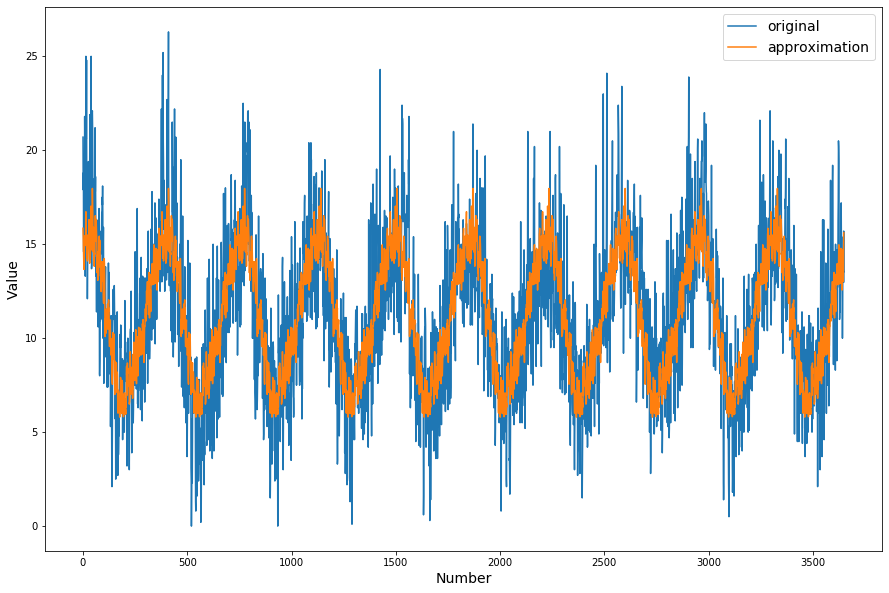

In [5]:
plt.figure(figsize=(15, 10))
plt.plot(x, label='original')
plt.plot(A.dot(z), label='approximation')
plt.legend()
plt.xlabel('Number', fontsize=FONTIZE)
plt.ylabel('Value', fontsize=FONTIZE)
plt.legend(fontsize=FONTIZE)

If your solution is correct, you see that the obtained periodic approximation is **non-smooth**.

To ensure the smoothness in our periodic approximation, consider the following **regularized** least-squares problem:

$$L(z) = ||Az - x||^2 + \lambda R(z) \to \min_z ,$$

where $R(z)$ is some regularization term and $\lambda > 0$.
The term $R(z)$ reflects our additional assumptions on the smoothness of the periodic approximation $z$. One of the possible form of this term is:

$$ R(z) = \sum_{i=1}^m (z_{i+1} - z_i)^2.$$

Another form of the same regularization term is:

$$R(z) =  \|Dz\|_2^2.$$

Intuitevely, the regularization term aims to penalize "sharp" series, and the parameter $\lambda$ provides a trade-off between approximation quality (the first term) and the smoothness degree (the second term). Note, the case $\lambda = 0$ corresponds to the previously obtained solution $z^*$ (why?).
 



_2._ Your second task is to find the best **smooth** periodic approximation $z^*_s$ of the original data $x$.

- (5 pts) Implement function to construct matrix $D$ according to the template provided below. Don't forget about periodicity! What is the meaning of $D$?

In [6]:
def build_D(m):
    '''
    Input: positive integer m
    Output: np.array of size (m, m)
    '''
    upper_eye = np.eye(m - 1, m)[::-1, ::-1]
    zeros = np.zeros(m)
    zeros[0] = 1
    upper_eye = np.vstack([upper_eye, zeros])
    return np.eye(m, m) - upper_eye

D = build_D(z.shape[0])

In [7]:
D, D.shape

(array([[ 1., -1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1., -1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  1., -1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1., -1.],
        [-1.,  0.,  0., ...,  0.,  0.,  1.]]), (365, 365))

- (3 pts) The optimality condition for the ordinary least-squares problem was derived during the lecture course. Using the same technique, for a given $\lambda$ derive an analog of the **normal equation** for the regularized least-squares problem formulated above.


$\large\frac{\partial{L(z)}}{\partial{z}} = \frac{\partial{\big((Az - x)^T(Az - x) + \lambda z^TD^TDz\big)}}{\partial{z}} = \small 2\big(A^T(Az - x) + \lambda D^TDz\big) = \small 2\big((A^TA + \lambda D^TD)z + A^Tx\big) = 0 \rightarrow z = (A^TA + \lambda D^TD)^{-1}A^Tx$

- (1 pts) Solve the derived system. You are supposed to use previously constructed matrices $A$ and $D$.

In [8]:
lmbda = 1. # You are supposed to play with parameter $\lambda$ during your study

matrix = np.linalg.inv((A.T).dot(A) + lmbda * (D.T).dot(D)).dot(A.T)

z_s = np.dot(matrix, x)

- (2 pts) Plot the original data $x$ and smooth periodic approximation $Az^*_s$ for three increasing values of $\lambda$. You have to get three plots with two time series $x$ and $Az^*_s$ in every plot. How $\lambda$ affects plots?

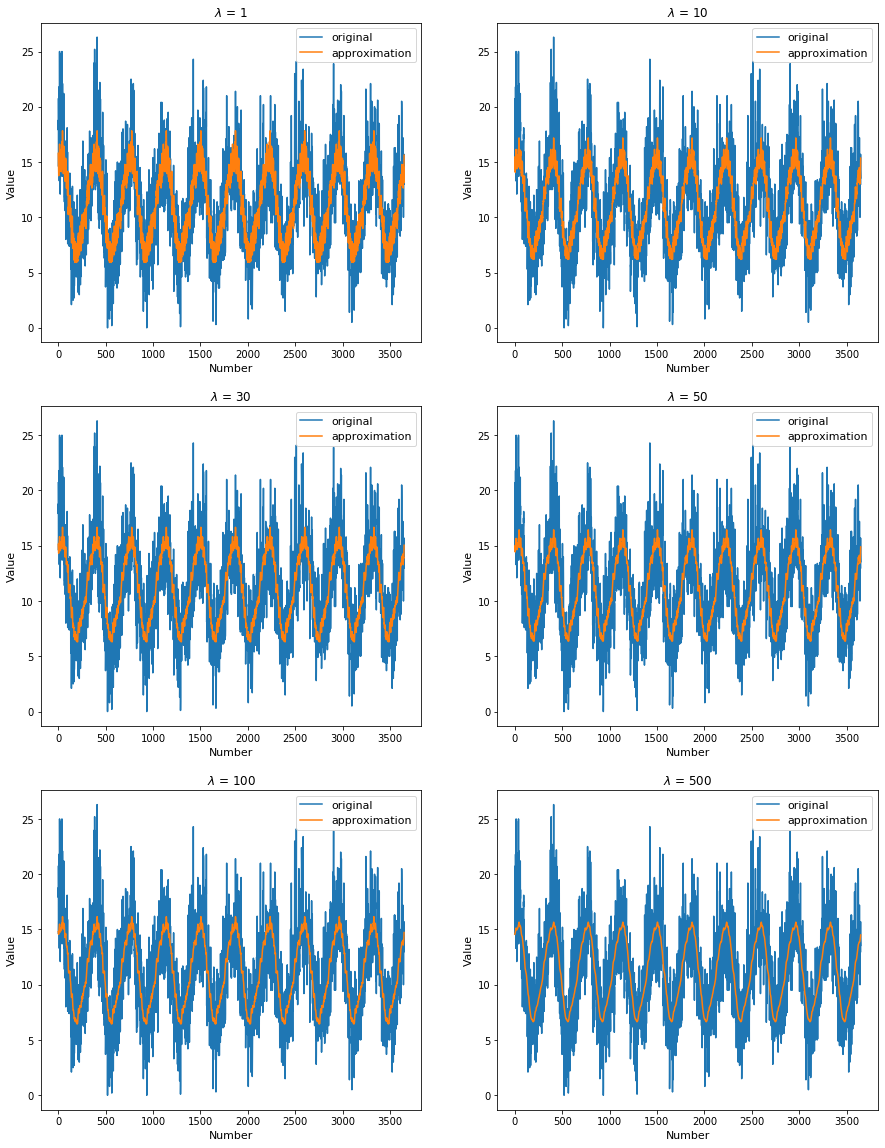

In [9]:
lmbdas = [1, 10, 30, 50, 100, 500]

plt.figure(figsize=(15, 20))
for i, lmbda in enumerate(lmbdas):
    matrix = np.linalg.inv((A.T).dot(A) + lmbda * (D.T).dot(D)).dot(A.T)
    z_s = np.dot(matrix, x)
    plt.subplot(3, 2, i + 1)
    plt.plot(x, label='original')
    plt.plot(A.dot(z_s), label='approximation')
    plt.legend()
    plt.xlabel('Number', fontsize=11)
    plt.ylabel('Value', fontsize=11)
    plt.title(f'$\lambda$ = {lmbda}')
    plt.legend(fontsize=11)

Increasing lambda is equivalent to making a loss part responsible for smoothing more important, therefore it makes final approximation smoother.

_3._ The final step is to build a model for predicting time series.

_-_ We want to predict $x_{k+1}$ based on $M$ previous observations.

_-_ Consider the following (linear) auto-regression (AR) model:

$$\hat{x}_{k+1} = \theta_1 x_k + \theta_2 x_{k-1} + \ldots + \theta_M x_{k-M+1},$$

with $M$ parameters $\theta_1, \ldots, \theta_M$ to be determined.

_-_ We fit the parameters by minimizing squared norm of the residual (again!):
    
$$(\hat{x}_{M+1} - x_{M+1})^2 + \ldots + (\hat{x}_n - x_n)^2 \to \min_{\mathbf{\theta}}.$$
    
_-_ This problem can be reformulated in a familiar form:

$$||X\theta - \tilde{x}||_2^2 \to \min_{\theta},$$

where $\tilde{x} = [x_{M+1}, x_{M+2}, \ldots, x_n]$.

- (7 pts) Implement function that constructs matrix $X \in \mathbb{R}^{(n-M) \times M}$ according to the template below. What structure does it have? Use appropriate function from ```NumPy/SciPy``` stack. 


The first row of the matrix $X$ is $(x_1, x_2 ... x_M)$, the second one is $(x_2, x_3 ... x_{M+1})$ etc.

In [10]:
from scipy.linalg import circulant

def build_X(x, M):
    '''
    Input: np.array of size n, positive integer M
    Output: np.array of size (n - M, M)
    '''
    X = circulant(x[::-1])[::-1]
    return X[:x.shape[0] - M, :M]

In [11]:
build_X(np.arange(10), 3)

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8]])

Note, that the previously obtained smooth periodic approximation $z_s$ by itself can be regarded as a predictive model. However, we want to include the noise term in the model too, by fitting it with AR model:

In [12]:
x_n = x - A @ z_s # Extract noise
train_x = x_n[:x_n.shape[0] // 2] #  Train data to fit the model
test_x = x_n[x_n.shape[0] // 2:] #  Test data to validate the model
M = 3 # You are supposed to find the best parameter $M$ during your study
X_train = build_X(train_x, M)

- (3 pts) Once you constructed $X$ based on the training data, the fitting of the parameters $\theta$ again requires the solution of the linear least-squares problem. This time you are supposed to compute pseudoinverse of $X$ via QR decomposition. Hint: use ```numpy.linalg.qr()``` function.

$A = QR$

$(A^TA)^{-1}A^T = (R^TQ^TQR)^{-1}R^TQ^T = (R^TR)^{-1}R^TQ^T = R^{-1}(R^T)^{-1}R^TQ^T = R^{-1} Q^T$

In [13]:
def build_pseudoinverse_QR(A):
    '''
    Input: np.array of size (n - M, M)
    Output: np.array of size (M, n - M)
    '''
    Q, R = np.linalg.qr(A)
    return np.linalg.inv(R) @ Q.T

X_inv = build_pseudoinverse_QR(X_train)
theta = X_inv @ train_x[M:]

- (3 pts) Check your model with test data. Plot your predicted noise series and test noise series in one plot. Next, add smooth trend $Az_s$ back to predicted noise series and plot it with the original series $x$ in one plot. You have to get two plots with two time series in every plot. Be careful with indexing!

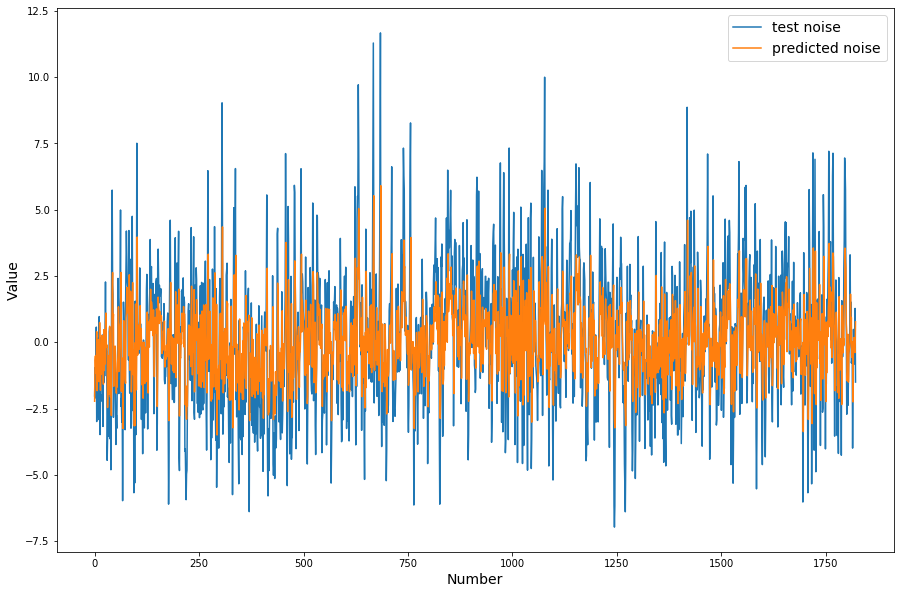

In [14]:
test_X = build_X(test_x, M)
predicted = test_X @ theta

plt.figure(figsize=(15, 10))
plt.plot(test_x[3:], label='test noise')
plt.plot(predicted, label='predicted noise')
plt.legend()
plt.xlabel('Number', fontsize=FONTIZE)
plt.ylabel('Value', fontsize=FONTIZE)
plt.legend(fontsize=FONTIZE)

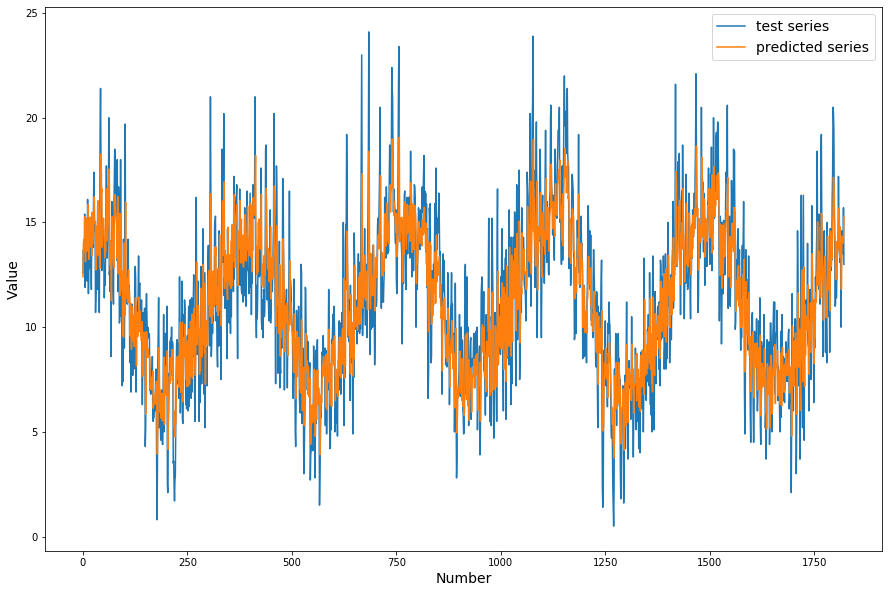

In [15]:
test_X = build_X(test_x, M)
predicted = test_X @ theta

plt.figure(figsize=(15, 10))
plt.plot(x[x_n.shape[0] // 2 + 3:], label='test series')
plt.plot(predicted + A[x.shape[0] // 2 + 3:] @ z_s, label='predicted series')
plt.legend()
plt.xlabel('Number', fontsize=FONTIZE)
plt.ylabel('Value', fontsize=FONTIZE)
plt.legend(fontsize=FONTIZE)

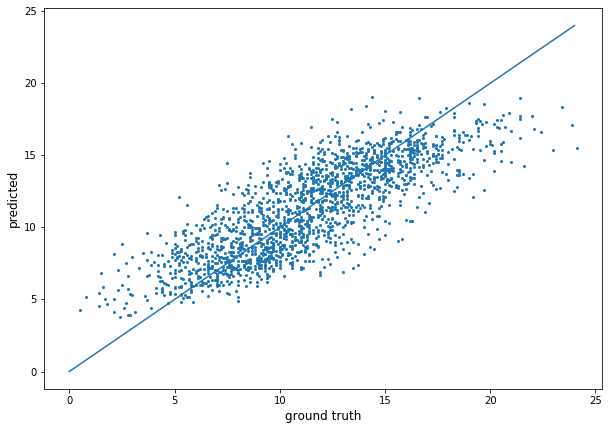

In [16]:
plt.figure(figsize=(10, 7))
plt.scatter(x[x_n.shape[0] // 2 + 3:], predicted + A[x.shape[0] // 2 + 3:] @ z_s, label='test series', s=4);
plt.plot(np.arange(25), np.arange(25))
plt.xlabel('ground truth', fontsize=12)
plt.ylabel('predicted', fontsize=12);

Let's find the best M by measuring MSE metric.

In [17]:
def compute_loss(m):
    X_train = build_X(train_x, m)
    X_inv = build_pseudoinverse_QR(X_train)
    theta = X_inv @ train_x[m:]
    test_X = build_X(test_x, m)
    predicted = test_X @ theta
    return np.linalg.norm(x[x_n.shape[0] // 2 + m:] - (predicted + A[x.shape[0] // 2 + m:] @ z_s), 2)

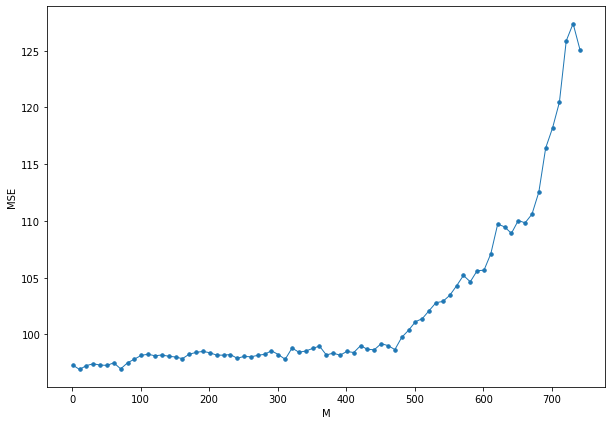

In [18]:
grid = np.arange(1, 750, 10)
losses = [compute_loss(m) for m in grid]
plt.figure(figsize=(10, 7))
plt.scatter(grid, losses, s=12)
plt.plot(grid, losses, linewidth=1)
plt.xlabel('M')
plt.ylabel('MSE');

We see that proper values of M lie somewhere in a range [1, 100].

In [19]:
best_m = np.argmin([compute_loss(m) for m in range(1, 100)]) + 1
best_m

6

- (Bonus) How valuable is your model for real time prediction? Try to perform honest time-marching with your model starting from $x_{M+1}$ to $x_{M+100}$. Is it still good? Try to choose the best parameters $M$ and $\lambda$.


In [20]:
# Your solution is here

# Problem 2 (Theoretical tasks)  (31 pts)

_1._
- (1 pts) what are the constants $C_1$ and $C_2$ such that $C_1 \|x\|_{\infty} \leq \|x\|_2 \leq C_2 \| x\|_{\infty}$
- (5 pts) Prove that $\| U A \|_F = \| A U \|_F = \| A \|_F$ for any unitary matrix $U$.
- (5 pts) Prove that $\| U A \|_2 = \| A U \|_2 = \| A \|_2$ for any unitary matrix $U$.
  
_2._
- (5 pts) Using the results from the previous subproblem, prove that $\| A \|_F \le \sqrt{\mathrm{rank}(A)} \| A \|_2$. _Hint:_ SVD will help you.
- (5 pts) Show that for any $m, n$ and $k \le \min(m, n)$ there exists $A \in \mathbb{R}^{m \times n}: \mathrm{rank}(A) = k$, such that $\| A \|_F = \sqrt{\mathrm{rank}(A)} \| A \|_2$. In other words, show that the previous inequality is not strict.
- (5 pts) Prove that if $\mathrm{rank}(A) = 1$, then $\| A \|_F  = \| A \|_2$.
- (5 pts) Prove that $\| A B \|_F \le \| A \|_2 \| B \|_F$.

#### 1.1
As all norms are positive definite,
$$C_1 \max_{i}|x_i| \leq \sqrt{\sum_i x_i^2} \leq C_2 \max_{i}|x_i| \iff C_1^2 (\max_{i}|x_i|)^2 \leq \sum_i x_i^2 \leq C_2^2 (\max_{i}|x_i|)^2$$
$$C_1^2 (\max_{i}|x_i|)^2 \leq \sum_i x_i^2 \iff C_1^2 \max_{i}x_i^2 \leq \sum_i x_i^2, \text{but} \ \max_{i}x_i^2 \leq \sum_i x_i^2 \ \ \forall x,$$
because the maximum is already presented in the sum and all elements in the sum are positive, therefore all $C_1$ in range $(0, 1]$ are appropriate.
$$\sum_i x_i^2 \leq C_2^2 (\max_{i}|x_i|)^2 = C_2^2 \max_{i}x_i^2$$
Let's denote dimensionality of $x$ as $n$.
$$\sum_i x_i^2 \leq n \max_{i}x_i^2 \Rightarrow C_2 = \sqrt{\sum_i x_i^2} \leq \sqrt{n} \max_{i}|x_i|$$
Thus $C_2$ can be drawn from $[\sqrt{n}, +\infty)$.

Answer: $C_1 = 1$, $C_2 = \sqrt{n}$.

#### 1.2
$$\operatorname{tr} UA = \operatorname{tr} u_{ij}a_{jk} = u_{ij}a_{ji} = a_{ji}u_{ij} = \operatorname{tr} AU \Rightarrow \operatorname{tr} UA = \operatorname{tr} AU$$
$$\|A\|_F^2 = tr A^*A \Rightarrow  \|UA\|_F^2 = \operatorname{tr} (UA)^*UA = \operatorname{tr} A^*U^*UA = \operatorname{tr} A^*A = \|A\|_F^2 \Rightarrow \|UA\|_F^2 = \|A\|_F^2$$
$$\|AU\|_F^2 = \operatorname{tr} (AU)^*AU = \operatorname{tr} AU(AU)^* = \operatorname{tr} AUU^*A^* = \operatorname{tr} AA^* = \|A\|_F^2$$
$$\|UA\|_F^2 = \|AU\|_F^2 = \|A\|_F^2$$

#### 1.3
$$ABx = \lambda x \Rightarrow BABx = BA(Bx) = \lambda (Bx)$$
Hence, AB and BA have the same eigenvalues.
$$\|UA\|_2^2 = \lambda_{max} \big[(UA)^*(UA)\big] = \lambda_{max} \big[A^*U^*UA)\big] = \lambda_{max} \big[A^*A\big] = \|A\|_2^2$$
$$\|AU\|_2^2 = \lambda_{max} \big[(AU)^*(AU)\big] = \lambda_{max} \big[(AU)(AU)^*\big] = \lambda_{max} \big[AUU^*A^*)\big] = \lambda_{max} \big[AA^*\big] = \|A\|_2^2$$
$$\|UA\|_2^2 = \|AU\|_2^2 = \|A\|_2^2$$

#### 2.1

$$||A||_{F}^2 = \operatorname{Tr}(A^{*}A),\ ||A||_{2}^2 = \lambda_{max}(A^{*}A)$$
   
Since $rank(A)$ is amount of non-zero sigular values of $A$ and  $A = U \Sigma V^{*}$, where $U,\ V$ are unitary and $\Sigma$ is diagonal,
   
$$||A||_{F}^2 = \operatorname{Tr}(\Sigma^{*}\Sigma) = \sum_{i}(\sigma_{i}^2), \ ||A||_{2}^2 = \lambda_{max} (\Sigma^{*}\Sigma) = \sigma_{1}^2(A)$$
   
Denoting $rank(A) = r$ we get for non-zero sigma's
   
$$\sum_{i=1}^{r}(\sigma_{i}^2) \le \sigma_{1}^2 \times r,$$ as $\sigma_1$ is the largest singular value, which immediately proves that $||A||_{F} \le \sqrt{rank(A)} \times ||A||_{2}$
   
#### 2.2

There exists $A \in \mathbb{R}^{m \times n}$ matrix of rank $k$ with $k$ equal nonzero singular values. To construct it we can just pick $\Sigma \in \mathbb{R}^{k \times k} = diag(\sigma_1,...,\sigma_1)$ (as scalar nonzero matrix of rank $k$) and multiply it by two unitary matrix U and V (i.e., A may be identity matrix appended by zeros to the rigth and to the bottom).
  
#### 2.3

$rank(A) = 1 \Rightarrow$ $A$ has only one non-zero singular value $\sigma_1$. Then
   
$$||A||_{F}^2 = \operatorname{Tr}(\Sigma^{*}\Sigma) = \sigma_{1}^2 = ||A||_{2}^2$$
   
#### 2.4

$$A = U_1 \Sigma_1 V_1^{*}, \ \ B = U_2 \Sigma_2 V_2^{*}$$
   
Since $\Sigma_1$ and $\Sigma_2$ are diagonal,
$$||AB||_{F}^2 = \operatorname{Tr}((AB)^{*}AB) = \operatorname{Tr}(B^{*}A^{*}AB) = \operatorname{Tr}(V_2\Sigma^{*}_2U^{*}_2 V_1\Sigma^{*}_1U^{*}_1 U_1 \Sigma_1 V_1^{*} U_2 \Sigma_2 V_2^{*}) = \operatorname{Tr}(\Sigma^{*}_1\Sigma_1 \Sigma_2^{*} \Sigma_2)$$
   
$$||A||_{2}^2 = \sigma_1^2(A), \ \ ||B||_{F}^2 = \operatorname{Tr}(\Sigma_2^{*} \Sigma_2) = \sum_{i} \sigma_i^2(B)$$
   
$$\operatorname{Tr}(\Sigma^{*}_1\Sigma_1 \Sigma_2^{*} \Sigma_2) = \sum_{i=1}^r \sigma_i^2(A) \sigma_i^2(B)$$
   
Since $\sigma_1(A)$ is the largest singular value of $A$,

$$\sum_{i=1}^r \sigma_i^2(A) \sigma_i^2(B) \le \sum_{i=1}^r \sigma_1^2(A)\sigma_i^2(B)$$

$$\| A B \|_F \le \| A \|_2 \| B \|_F$$

# Problem 3 (Matrix calculus) (15 pts)

_1._ (5 pts) Consider the following function

$$ F(U, V) = \frac{1}{2}\|X - UV\|_F^2, $$

where $X \in \mathbb{R}^{n \times n}$, $U \in \mathbb{R}^{n \times k}$ and $V \in \mathbb{R}^{k \times n}$ and $k < n$. 

- (2 pts) Derive analytical expression for the gradient of the function $F$ with respect to $U$ 
- (2 pts) Derive analytical expression for the gradient of the function $F$ with respect to $V$
- (1 pts) Estimate computational complexity of computing these gradients (in big-O notation). 

_2._ (2 pts) Derive analytical expression for the gradient of the function $f$:

$$ R(x) = \frac{(Ax, x)}{(x, x)}, $$

where $A$ is a symmetric real matrix. Why the gradient of this function is important in NLA you will know in the lectures later.

_3._ (8 pts) Consider the following function $f$ 

$$f(w) = \log\det\left(\sum_{i=1}^m w_i x_i x_i^{\top}\right),$$

where $x_i, \; i = 1,\dots,m$ are given column vectors. 


- (3 pts) Derive analytical expression for the gradient of $f$
- (1 pts) For what values of $m$ and vectors $x_i$ the function $f$ makes sense and is finite?
- (4 pts) Consider two approaches to compute it: directly with matrix products and so on and the single-line solution with ```einsum``` function.   
Generate some set of vectors $x_i \in \mathbb{R}^{1000}$ such that the funtion $f$ is finite and compare the time of computing derived gradient with these approaches. Use [%timeit](https://docs.python.org/3.6/library/timeit.html) command to measure time. What do you think about the reason of such behaviour? 

#### 1
$$ F(U, V) = \frac{1}{2}\|X - UV\|_F^2 = \frac{1}{2} \operatorname{Tr} ( X - UV )^T ( X - UV ) = \frac{1}{2}\operatorname{Tr} \Big[ (X_{ij} - U_{ik}V_{kj})(X_{il} - U_{ik}V_{kl}) \Big] = $$ $$ =  \frac{1}{2}(X_{ij} - U_{ik}V_{kj})(X_{ij} - U_{ik}V_{kj}) = \frac{1}{2} (X_{ij} - U_{ik}V_{kj})^2$$

Here by square we mean sum by both i and j of squares of the elements.

$$\frac{\partial F}{\partial U_{mn}} = -V_{nj} \cdot (X_{mj} - U_{mk}V_{kj}) = (UV - X)V^T $$

$$\frac{\partial F}{\partial V_{mn}} = -U_{im} \cdot (X_{in} - U_{ik}V_{kn}) = U^T (UV - X) $$

Complexity:

* Computing $(UV - X)$ is $O(n^2k + n^2) = O(n^2k)$. The resulting matrix is $n \times n$.
* Multiplying $(UV - X)$ by $V^T$ gives us $O(n^2k + n^2k) = O(n^2k)$.
* Multiplying $U^T$ by $(UV - X)$ gives us the same complexity.

Thus, complexity in both cases is $O(n^2k)$.



#### 2
$$R(x) = \frac{A_{ij}x_jx_i}{x_kx_k} \Rightarrow \frac{\partial R}{\partial x_n} = \frac{A_{in}x_i + A_{nj}x_j}{x_kx_k} - 2\frac{A_{ij}x_jx_i}{(x_kx_k)^2}x_n = \frac{x^TA + Ax}{(x, x)} - 2 \frac{(Ax, x)}{(x, x)^2}x$$
Since a is a symmetric matrix,
$$\frac{\partial R}{\partial x} = \frac{2Ax}{(x, x)} - 2 \frac{(Ax, x)}{(x, x)^2}x$$

#### 3

$$f(w) = \log\det\left(\sum_{i=1}^m w_i x_i x_i^{\top}\right)$$

According to [the formula](https://en.wikipedia.org/wiki/Determinant#Derivative),

$$\frac{\partial \det A}{\partial \alpha} = \det \left(A\right)  \operatorname{Tr}\left(A^{-1} \frac{\partial A}{\partial \alpha}\right)$$

$$\frac{\partial f}{\partial w_j} = \frac{1}{\det\left(...\right)} \cdot \frac{\partial \det \left(...\right)}{\partial w_i} = \frac{1}{\det\left(...\right)} \cdot \det\left(...\right) \operatorname{Tr \Big[ \Big(\sum_{i=1}^m w_i x_i x_i^{\top}}\Big)^{-1} x_j x_j^{\top}\Big] = \operatorname{Tr \Big[ \Big(\sum_{i=1}^m w_i x_i x_i^{\top}}\Big)^{-1} x_j x_j^{\top}\Big] $$

The formula implies strictly positive determinant, as we need to take logarithm of it. So $w$ has to have at least $\operatorname{dim} x_i$ non-zero components, and $m \geq \operatorname{dim} x_i,$ because $x_ix_i^T$ is a singular matrix for any given $i$, and we need at least $\operatorname{dim} x_i$ linearly independent vectors to combine them into non-singular matrix.

In [101]:
def make_matrix(dim_xi):
    x = np.random.randn(dim_xi).reshape(dim_xi, 1)
    return x @ x.T

print(np.linalg.det(sum([make_matrix(10) for _ in range(9)])))
print(np.linalg.det(sum([make_matrix(10) for _ in range(10)])))

-2.2036756969164588e-10
95108.90462739371


Here we see that sum of $m \lt \operatorname{dim}x_i$ matrices constructed following the aforementioned rule produces zero determinant.

In [109]:
X = np.random.randn(1000, 1000)
w = np.random.randn(1000)

In [ ]:
np.einsum('ij,mn,k->', X, X, w)

In [ ]:
np.einsum('i->i', )

In [ ]:
%time
np.einsum('' X)

# Problem 4. Compression of the fully-connected layers in neural network with simple architecture (20 pts)

In this problem we consider the neural network that performs classification of the dataset of images. 
Any neural network can be considered as composition of simple linear and non-linear functions.
For example, a neural network with 3 layers can be represented as 

$$f_3(f_2(f_1(x, w_1), w_2), w_3),$$

where $x$ is input data (in our case it will be images) and $w_i, \; i =1,\dots,3$ are parameters that are going to be trained. 

We will study the compression potential of neural network with simple architecture: alternating some numbers of linear and non-linear functions. 

The main task in this problem is to study how the compression of fully-connected layers affects the test accuracy.
Any fully-connected layer is represented as linear function $AX + B$, where $X$ is input matrix and $A, B$ are trainable matrices. Matrices $A$ in every layer are going to be compressed.
The main result that you should get is the plot of dependence of test accuracy on the total number of parameters in the neural network.

#### Zero step: install PyTorch

- Follow the steps in [official instructions](https://pytorch.org/get-started/locally/)

#### First step: download CIFAR10 dataset

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=True, download=True, transform=transform), 
                                        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=False, transform=transform), 
                                          batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### Check what images are we going to classify

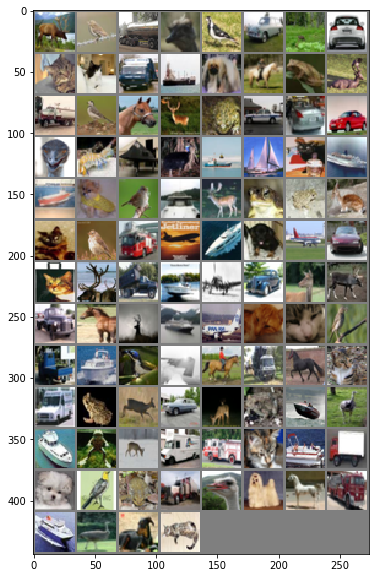

 deer  bird truck  bird  bird   car  deer   car


In [23]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


### Second step: neural network architecture

For simplicity and demonstration purposes of the neural network compression idea consider the architecture consisting of the only fully-connected layers and non-linear ReLU functions between them.
To demonstrate compression effect, consider the dimension of the inner layers equals to 1000.

Below you see implementation of such neural network in PyTorch.
More details about neural networks you will study in the *Deep learning* course in one of the upcoming term

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 1000)
        self.fc6 = nn.Linear(1000, 10)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)
        x = self.ReLU(x)
        x = self.fc5(x)
        x = self.ReLU(x)
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

#### Implement functions for training and testing after every sweep over all dataset entries

In [25]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [26]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Set parameters for training and print intermediate loss values

In [27]:
log_interval = 50
epochs = 7

### Third step: run training with the [Adam](https://arxiv.org/pdf/1412.6980.pdf%20%22%20entire%20document) optimization method

If your laptop is not very fast, you will wait some time till training is finished. 

In [28]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    train(model,  train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302557
Train Epoch: 1 [5000/50000 (10%)]	Loss: 2.057592
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.852170
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.774853
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.785047
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.711913
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.788670
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.649183
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.655746
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.613407

Test set: Average loss: 1.5620, Accuracy: 4394/10000 (44%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.614625
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.390562
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.481693
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.587467
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.636905
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.330408
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.547454
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.520977
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.498137
T

Now we have somehow trained neural network and we are ready to perform compression of the weigths in the fully-connected layers.

- (3 pts) Compute SVD of the matrix $1000 \times 1000$, which corresponds to a weight matrix $A$ in any layer of the trained neural network of the appropriate dimension. To find more information about accessing this matrix please refer to [PyTorch manual](https://pytorch.org/docs/stable/index.html).
Plot decaying of the singular values like it was shown in the lecture. What conclusion can you make?
- (12 pts) Create a new model, which is analogue to the class ```Net```, but with some significant distinctions. 
It takes as input parameters the instance of the class ```Net``` and compression rank $r > 0$. 
After that, this model has to compress all matrices $A$ in fully-connected layers with SVD using first $r$ singular vectors and singular values.
Pay attention to efficiently storing of compress representation of the layers.
Also ```forward``` method of your new model has to be implemented in a way to use compressed representation of the fully-connected layers. In all other aspects it has to reproduce ```forward``` method in the original non-compressed model (number of layers, activations, loss function etc).
- (5 pts) Plot dependence of test accuracy on the number of parameters in the compressed model. This number of parameters obviously depends on the compression rank $r$.
Also plot dependence of time to compute inference on the compression rank $r$.
Explain obtained results.
To measure time, use [%timeit](https://docs.python.org/3.6/library/timeit.html) with necessary parameters (examples of using this command see in lectures) 

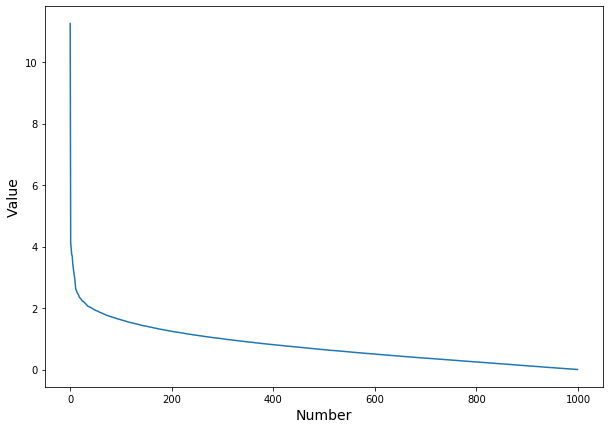

In [29]:
weight = model.fc4.weight.data.numpy()
U, S, V = np.linalg.svd(weight)

plt.figure(figsize=(10, 7))
plt.plot(S)
plt.xlabel('Number', fontsize=14)
plt.ylabel('Value', fontsize=14);

We see, that singular values rapidly decrease, therefore we can drop some rows and columns of both matrices U and V correspondingly to save some RAM space :)

To do so, we will create a class inherited from Sequential model and fill its base with the layers of a given model, compressing them via CompressedLinear class.

In [30]:
class CompressedLinear(torch.nn.Module):
    def __init__(self, weight, bias, r):
        super().__init__()
        U, S, V = np.linalg.svd(weight.data.T)
        r = min(r, S.shape[0])
        self.U = torch.tensor(U[:, :r], requires_grad=True)
        self.S = torch.tensor(S[:r], requires_grad=True)
        self.V = torch.tensor(V[:r], requires_grad=True)
        self.bias = torch.tensor(bias.data, requires_grad=True)
        
    def forward(self, X):
        return X @ (self.U * self.S @ self.V) + self.bias

def yeild_pairs(parameters):
    yieldable = []
    for param in parameters:
        yieldable.append(param)
        if len(yieldable) > 1:
            yield yieldable
            yieldable = []
        
class Flatten(torch.nn.Module):
    def forward(self, X):
        return X.reshape(X.shape[0], -1)
        
class CompressedNet(torch.nn.Sequential):
    def __init__(self, model, r):
        layers = [Flatten()]
        for weight, bias in yeild_pairs(model.parameters()):
            layers.append(CompressedLinear(weight, bias, r))
            layers.append(torch.nn.ReLU())
        del layers[-1]
        super().__init__(*layers)

Then we want to know how does the compression strength affects the accuracy of the obtained model.

In [31]:
def compute_metrics(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    return correct / len(test_loader.dataset)

In [32]:
compute_metrics(model, test_loader)

0.5355

So it's the accuracy of the initial model, it shouldn't have changed and it did not :)

In [33]:
from tqdm import tqdm
from warnings import filterwarnings
from IPython.display import clear_output
filterwarnings('ignore')

logs = []
grid = [500, 600, 700, 800, 850, 900, 925, 950, 966, 975, 985, 990, 995, 999]
for n_dropped in tqdm(grid):
    compressed_model = CompressedNet(model, 1000 - n_dropped)
    logs.append(compute_metrics(compressed_model, test_loader))
    clear_output(True)

100%|██████████| 14/14 [01:11<00:00,  4.44s/it]


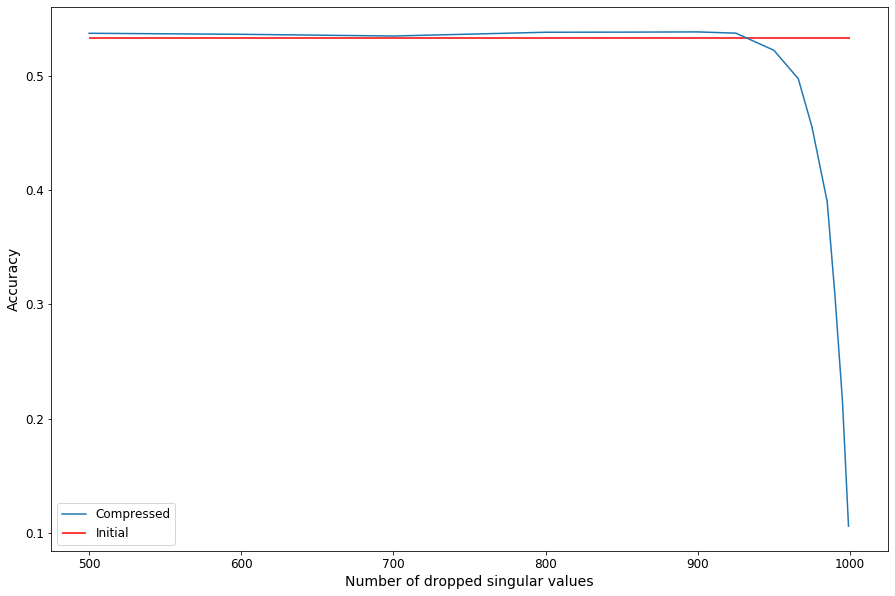

In [34]:
plt.figure(figsize=(15, 10))
plt.plot(grid, logs, label='Compressed')
plt.hlines(0.5334, 500, 1000, colors='red', label='Initial')
plt.xlabel('Number of dropped singular values', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [35]:
np.sum(np.array(logs) > 0.5334)

7

Wee see that at some points the quality of prediction even increased a bit! Anyway, let's look at the tail closer...

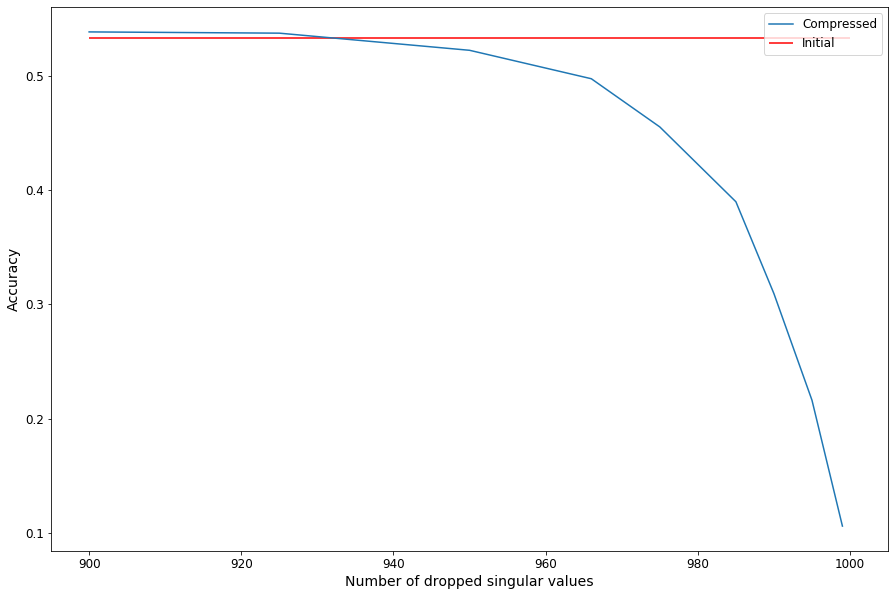

In [36]:
plt.figure(figsize=(15, 10))
plt.plot(grid[5:], logs[5:], label='Compressed')
plt.hlines(0.5334, 900, 1000, colors='red', label='Initial')
plt.xlabel('Number of dropped singular values', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

It means that we can compress our NN approximately 10 times without losing accuracy at all... What a miracle!

In [37]:
def count_params(model):
    count = 0
    for module in next(compressed_model.modules()):
        if isinstance(module, CompressedLinear):
            for attr in ['U', 'S', 'V', 'bias']:
                count += np.product(getattr(module, attr).shape)
    return count

In [38]:
logs = []
grid = np.arange(0, 1000, 50)
for n_dropped in tqdm(grid):
    compressed_model = CompressedNet(model, 1000 - n_dropped)
    logs.append(count_params(compressed_model))
    clear_output(True)

100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


In [39]:
initial_n_params = sum([np.product(param.shape) for param in model.parameters()])
initial_n_params

7087010

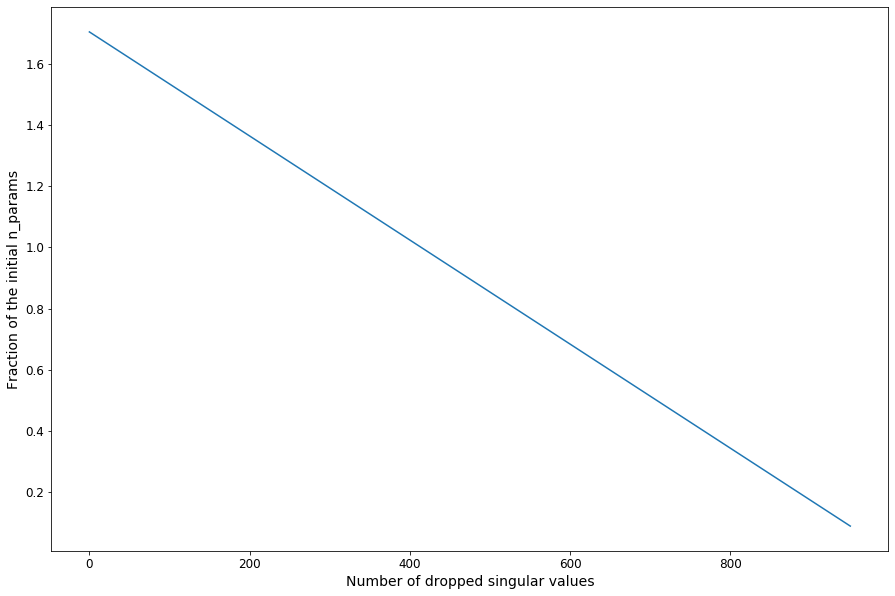

In [40]:
plt.figure(figsize=(15, 10))
plt.plot(grid, list(map(lambda x: x / initial_n_params, logs)), label='Compressed')
plt.xlabel('Number of dropped singular values', fontsize=14)
plt.ylabel('Fraction of the initial n_params', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [41]:
metrics = []
n_params = []
grid = [0, 100, 200, 300, 500, 600, 700, 800, 850, 900, 925, 950, 966, 975, 985, 990, 995, 999]
for n_dropped in tqdm(grid):
    compressed_model = CompressedNet(model, 1000 - n_dropped)
    metrics.append(compute_metrics(compressed_model, test_loader))
    n_params.append(count_params(compressed_model))
    clear_output(True)

100%|██████████| 18/18 [01:48<00:00,  4.75s/it]


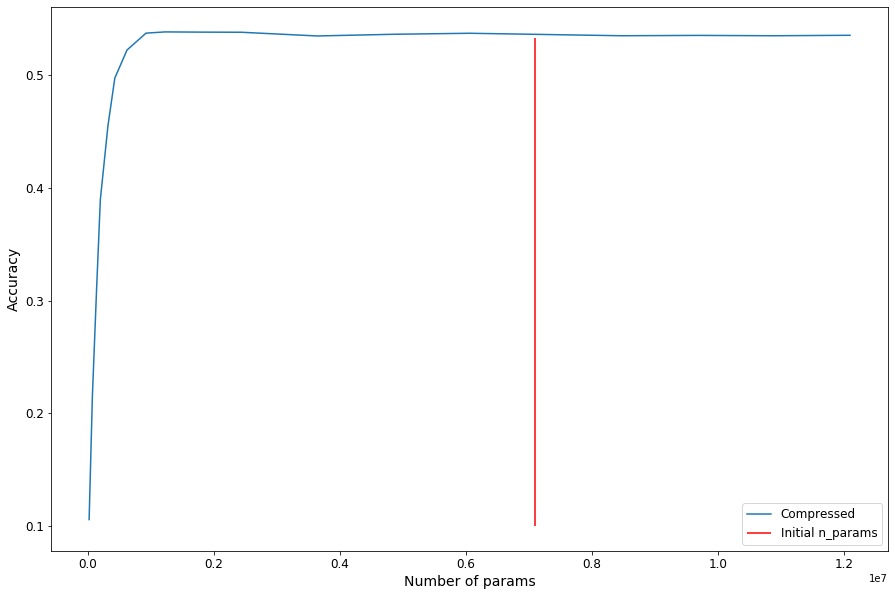

In [42]:
plt.figure(figsize=(15, 10))
plt.plot(n_params, metrics, label='Compressed')
plt.vlines(initial_n_params, 0.1, 0.5334, colors='red', label='Initial n_params')
plt.xlabel('Number of params', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

Let's measure forward time for the initial and the compressed models.

In [43]:
from timeit import timeit
n_times = 5
initial_time = timeit('compute_metrics(model, test_loader)', number=n_times, globals=globals()) / n_times
round(initial_time, 3)

2.285

In [44]:
logs = []
grid = [0, 100, 200, 300, 500, 600, 700, 800, 850, 900, 925, 950, 966, 975, 985, 990, 995, 999]
for n_dropped in tqdm(grid):
    compressed_model = CompressedNet(model, 1000 - n_dropped)
    logs.append(timeit('compute_metrics(compressed_model, test_loader)',
                      number=n_times, globals=globals()) / n_times)
    clear_output(True)

100%|██████████| 18/18 [07:05<00:00, 17.95s/it]


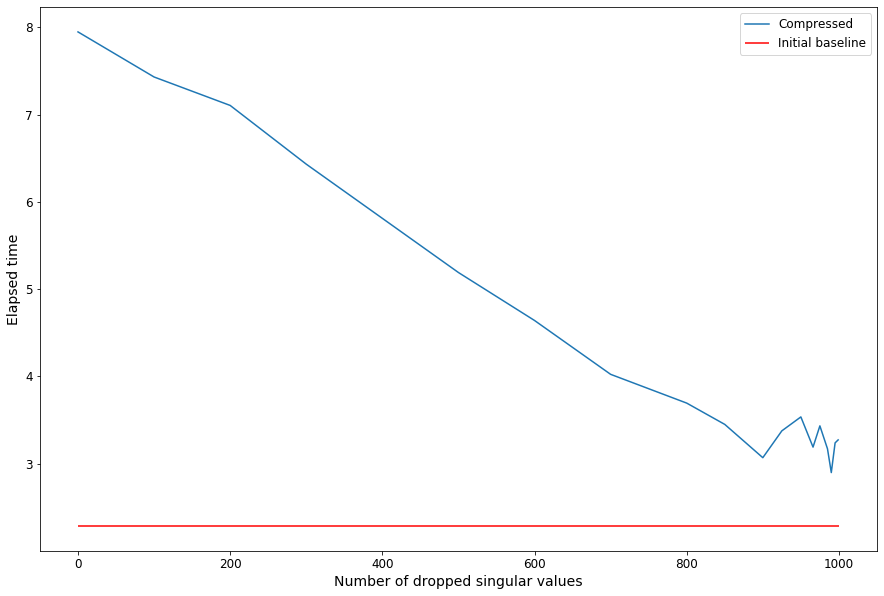

In [45]:
plt.figure(figsize=(15, 10))
plt.plot(grid, logs, label='Compressed')
plt.hlines(initial_time, 0, 1000, colors='red', label='Initial baseline')
plt.xlabel('Number of dropped singular values', fontsize=14)
plt.ylabel('Elapsed time', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

Ofc, torch linear layers are faster than our dummy sequence of matrix multiplications, but 2-3x loss in time is comparable to 10x storage optimization in some tasks.

# Problem 5 (Bonus)

1. The norm is called absolute if $\|x\|=\| \lvert x \lvert \|$ holds for any vector $x$, where $x=(x_1,\dots,x_n)^T$ and $\lvert x \lvert = (\lvert x_1 \lvert,\dots, \lvert x_n \lvert)^T$. Give an example of a norm which is not absolute.

2. Write a function ```ranks_HOSVD(A, eps)```
that calculates Tucker ranks of a d-dimensional tensor $A$ using High-Order SVD (HOSVD) algorithm, where ```eps``` is the relative accuracy in the Frobenius norm between the approximated and the initial tensors. Details can be found [here](http://ca.sandia.gov/~tgkolda/pubs/pubfiles/TensorReview.pdf) on Figure 4.3.
```python
def ranks_HOSVD(A, eps):
      return r #r should be a tuple of ranks r = (r1, r2, ..., rd)
```